# Checkpoint 1: Neural networks and deep learning
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)

In this checkpoint exercise, we will use neural networks to predict the **type** of weather *given* the available ground observations. You will be using observation data from **June 2019** across all UK Met Office weather stations.

### Notes on the Dataset
* You will be using weather observation data from the UK Met Office Datapoint service
* Ground observations are made hourly at weather stations across the length of the UK 
* The data sample covers data from June 2019
* Data collections for each day starts at 6.30pm. All observation data is listed in one day blocks
* The time value column refers to the number of minutes after midnight 
* `Null` values for some features are expected (e.g. Wind Gust)
* Data import and preparation is already provided 


This week, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** Think of these as LEGO blocks; you have the ones you need but may look up how to "assemble" them.

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 9 October 2021** 
- This CP exercise sheet is divided into **6 sections**, corresponding to parts of the lecture, giving a maximum of **10 marks** in total:

| <p align='left'> Title                         | <p align='left'> Exercise nos. | <p align='left'> Number of marks |
| ------------------------------------- | ----- | --- |
| <p align='left'> 1. Conceptual questions               | <p align='left'>  1–5  | <p align='left'> 2.5 |
| <p align='left'> 2. Data preprocessing and RandomForest                | <p align='left'>  6–9  | <p align='left'> 2.5 |
| <p align='left'> 3. Neural networks in `scikit-learn`  | <p align='left'>  10–11 | <p align='left'> 1.5 | 
| <p align='left'> 4. Neural networks in `Keras`         | <p align='left'> 12–13 | <p align='left'> 2 |
| <p align='left'> 5. Regularisation                     | <p align='left'> 14–15 | <p align='left'> 1.5 |
| <p align='left'> 6. Bonus: Hyperparameter optimisation | <p align='left'> 16 | <p align='left'> 1.0 (\*bonus\*) |
| <p align='left'> **Total** | | <p align='left'> **10 + 1** |

- The total number of marks allocated for this CP is 10,
    - 1 additional mark can be given (maximimally up to 10 marks in total) for "bonus" exercise on hyperparameter optimisation. If you are pressed for time, focus on the first five sections; those are the core ones.
    - Half marks may be deducted for code legibility (i.e. very difficult to tell what you are doing), or for badly formated plots (i.e. no legends, axis labels etc.). The TAs will use their discression for this so comment code when applicable and keep relevant information in your plots.

_Note:_ You can suppress double-printing of plots from the `plot` module by either _(a)_ adding a semicolon after the function call (_i.e._ `plot.<method>(...);`), or _(b)_ by capturing the return `pyplot.Figure` object as a variable (_i.e._ `fig = plot.<method>(...)`).

## Preamble

In [5]:
# Standard import(s)
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

# Suppress unnecessary ConvergenceWarGraph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 23), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'") at layer "dense_12". The following previous layers were accessed without issue: []nings and DeprecationWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Set a random seed variable to make workbook reproducible
seed=5
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
tf.compat.v1.set_random_seed(seed)

# Switch off multi-threading for TensorFlow
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
K.set_session(sess)

In [6]:
# Load in the prepared weather data
obs = pd.read_csv('weather.csv')
obs.head()

,StationID,StationName,Elevation,Latitude,Longitude,Date,Time,Gust,Temperature,Visibility,WindDirection,WindSpeed,Pressure,PressureTrend,DewPoint,Humidity,Type
0,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1020,NaN,16.1,30000.0,E,8.0,1019.0,F,11.6,74.5,0
1,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1080,NaN,14.9,22000.0,E,8.0,1019.0,F,11.8,81.5,0
2,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1140,NaN,14.0,14000.0,E,6.0,1018.0,F,11.6,85.4,0
3,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1200,NaN,12.9,12000.0,ENE,2.0,1019.0,R,11.0,88.1,0
4,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1260,NaN,12.0,9000.0,E,2.0,1019.0,R,10.9,92.9,1


In [7]:
obs.shape

(106553, 17)

In [8]:
obs.describe()

,StationID,Elevation,Latitude,Longitude,Time,Gust,Temperature,Visibility,WindSpeed,Pressure,DewPoint,Humidity,Type
count,106553.000000,106553.000000,106553.000000,106553.000000,106553.000000,7703.000000,106442.000000,92662.000000,102060.000000,99530.000000,106402.000000,106397.000000,106553.00000
mean,6147.845636,114.466594,53.673022,-2.829034,702.914418,33.043749,14.958912,25698.164404,8.999510,1018.748337,10.348008,76.185240,0.99603
std,15821.503845,171.669120,2.466079,2.269594,412.057262,13.424855,4.294516,14263.873943,6.087882,6.327468,3.120565,17.208653,0.92971
min,3002.000000,2.000000,49.207900,-10.250000,0.000000,0.000000,-1.200000,20.000000,0.000000,976.000000,-28.200000,0.800000,0.00000
25%,3204.000000,20.000000,51.565000,-4.149000,360.000000,29.000000,12.000000,14000.000000,5.000000,1015.000000,8.400000,65.300000,0.00000
50%,3414.000000,65.000000,53.175000,-2.663000,720.000000,32.000000,14.500000,25000.000000,8.000000,1018.000000,10.500000,79.200000,1.00000
75%,3769.000000,132.000000,55.285000,-1.097000,1020.000000,39.000000,17.500000,35000.000000,11.000000,1024.000000,12.500000,90.000000,1.00000
max,99142.000000,1245.000000,60.749000,1.348000,1380.000000,105.000000,31.600000,75000.000000,81.000000,1036.000000,22.700000,100.000000,3.00000


For this exercise we will use **8** input features (provided) and clean the data:

In [9]:
# Define 8 input feature variables, 1 target variable data, and names of the 3 weather types
features = ['Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity', 'WindDirection']
output   = ['Type']
wtype    = ['Clear', 'Cloudy', 'Precip']

Define derived dataset containing only the relevant columns and rows.

In [10]:
# Reduce to feature and type columns
dataset = obs[features + output]

# Drop duplicates and null values 
dataset = dataset.drop_duplicates().dropna()

# Drop unrecorded weather type
dataset = dataset[dataset.Type != 3]

# Check shape 
dataset.shape
#dataset.head(5000)
print(dataset.loc[[90176]])

       Latitude  Elevation  Temperature  Visibility  WindSpeed  Pressure  \
90176    53.174       10.0         20.4     23000.0       11.0    1027.0   

       Humidity WindDirection  Type  
90176      56.2           SSE     0  


## 1. Conceptual questions (2.5 Marks)
---
This section covers **5** exercises on conceptual understanding of neural networks.

#### 1. Which are the most used activation functions and why do we (typically) need non-linear activation functions in neural networks? (0.5 mark)

The most used activation functions are:
    
    Sigmoid Activation, Relu, Softmax and tanh

We typically need non-linear activation functions in neural networks, as without them hidden layers become useless as a composition of linear functions is just another linear function. Non-linear activation functions also allow for backpropagation (or gradient descent) while linear functions do not, as the derivative of a linear function has no relation to the input so it useless when trying to decide which weights produce a better prediction.

#### 2. Why do we need deep neural networks and which are the main differences between deep and shallow learning? (0.5 Mark)

- **Deep Learning** is when a neural network has at least 2 or more hidden layers, and so can exploit high dimensional data to perform feature extraction and deep combination simultaneously to get an output
- **Shallow Learning** has less than 2 hidden layers, and generally requires manual engineering and simple algorithms to get an output.


Deep neural networks allow for increases in performance that scale with the amount of data supplied much better than older learning algorithms, and give us the ability to exploit high-dimensional data rather than having us manually break it down into low-dimensional data. This can allow the DL-network to find relevant features that wouldn't be obvious to the user who is breaking down the high-dimensional data.

*Eg: The most important features for identifying cats can be determined by a human, and then plugged into a shallow combination system for an output. While in deep learning the high-dimensional 'cat' data can be plugged in directly and important features can be determined by the network itself and used to determine an output.*




#### 3. Discuss the Bias-variance trade-off and its relation to underfitting and overfitting of a model. Which are the charactheristics of an ideal model?  (0.5 mark)

The Bias-variance trade-off is the relationship between these two factors (bias and variance) and how they correspond to either good or bad models.

- Bias is a trainable parameter that shifts the activation function within a NN
- Variance is the variability in your model's prediction, or how much your results can shift based on the given dataset

An underfit model is one with high bias and low variance (so the model is inflexible and can't learn the relevant structure in the dataset). The high bias is attributed to poor performance on training data.

An overfit model is one with low bias and high variance (so the model is too flexible and can learn random structures that don't represent the dataset as a whole). Overfit models show high loss on testing datasets but low loss on training datasets.

#### 4. Given a neural network with 4 input nodes, 2 layers with 5 nodes each, and 1 output node, what is the total number of free (trainable) parameters in the network? Does it matter which activation function(s) are used?  (0.5 mark)

4 input nodes, 2 hidden layers of 5, and one 1 output mode.

5x4 + 5x5 + 5x1 + 5 + 5 + 1 = 61 total trainable parameters 

*__But this includes the input and output, is this correct?__*

Different activation functions are suitable for specific problems and allow for better training on specific problems when compared to their counterparts. ReLU for example is appropriate for regressing non-negative energy.

#### 5. What are appropriate choice for _(a)_ the number of output nodes and _(b)_ output activation function(s) for each of the following tasks, and why? (0.5 mark)

1. Regression of the $x$, $y$, and $z$ coordinates of a single particle in an arbitrary coordinate system
2. Regression of particle energy of a single particle
3. Classification of two processes (signal vs. background)
4. Classification among *N* classes (dog vs. cat vs. fish vs. ...)

a)

1. 3 output nodes, as we have x,y and z regression.
2. 1 output node, as we only have the particle energy.
3. 2 output nodes, for both signal and background (although I guess you could technically have one as long as p1+p2 = 1)
4. N output nodes (probability for each different class. dog, cat, fish, etc.)

b)

1. Linear, as the data involves regessing (but possibly negative) quantities. *__(ASK ABOUT THIS)__*
2. ReLU, as the data is involves regressing non-negative quantities.
3. Sigmoid, as this can be described as a binary classification probability (noise - 0, signal - 1).
4. Softmax, as this can be described as a multiclass classification probability.



## 2. Data preprocessing and RTs (2.5 mark)
---
This section covers **4** exercises on data preparation, feature standardisation, and dataset splitting.

In [11]:
# Relevant import(s) for this section
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

---
**_Comment on target format and one-hot encoding:_** By default, the target column (`Type`) contains one integer (0, 1, or 2) for each example, the integer specifying one of three possible types of weather. However, for doing multi-class classification (which this is), we want our neural network to have one output node per class (_i.e._ 3 output nodes in this case), such that the activation of each output node is interpreted as the likelihood for a given sample being of the type in question. Therefore, the target should also be a 3-element vector for each sample; this vector should be all zeros, except for a $1$ at the index corresponding to the type in question. This is called **one-hot encoding**, and a few examples are shown below:

- type = 0 $\to$ one-hot = $[1, 0, 0]$ for 3 classes
- type = 1 $\to$ one-hot = $[0, 1, 0]$ for 3 classes
- type = 2 $\to$ one-hot = $[0, 0, 1]$ for 3 classes

This is the target towards which a neural network classifier is trained: That is, ideally, for an example of type 0, the network will output a large activation ($\approx 1$) on the first output node (interpreted as a large likelihood for the first weather type), and very small activations ($\ll 1$) on the two other output nodes (intepreted as small likelihoods for the two other weather types); and so on.

The same type of one-hot encoding can be performed for any number of target classes $N_{c}$, which just results in $N_{c}$-element target vectors with a single non-zero entry each.

To be user friendly, however, `scikit-learn` allows us to use integer targets for multi-class classification — it does the one-hot encoding for us "under the hood." Similarly, `keras`, _can_ also allow us to use integer targets for multi-class classification, provided we use the appropropriate loss (`sparse_categorical_crossentropy`). Otherwise (if we use `categorical_crossentropy` loss), it expects one-hot encoded targets. Which approach you choose is up to you — but now you know what goes on.

---

#### 6. Prepare the feature and target arrays (0.5 mark)
- Randomly sample **3,500** observations per weather type (**10,500** observations in total) from `dataset` into a new `pandas.DataFrame`; call it `sample`.
- One-hot encode the **wind direction** variable (_i.e._ $N$ to $[1, 0, \ldots, 0]$, $NNE$ to $[0, 1, \ldots, 0]$, _etc._ ), to allow us to input it to the neural network. The exact order of the encoding (_i.e._ which direction corresponds to which index) doesn't matter. *Hint:*
  - *Either:* Use the scikit-learn `ColumnTransformer` with the `OneHotEncoder` applied to the `WindDirection` column, and let the remainder of the features pass through un-transformed.
  - *Or:* Use the `OneHotEncoder` class directly on the `WindDirection` column (use `sparse=False` in the `OneHotEncoder` constructor), and then concatenate with a `numpy.array` containing the remaining features.
- Define `numpy.arrays` named `X` and `y` containing the training features (the 7 unmodified ones plus the one-hot encoded wind directions) and target, respectively.
- Argue whether the shapes of `X` and `y` are as expected/as they should be.

In [64]:
# Shuffle the dataset
dataset = dataset.sample(frac = 1)

# Setting up samples for each dataset type
sample0 = dataset[dataset['Type'] == 0].head(3500)
sample1 = dataset[dataset['Type'] == 1].head(3500)
sample2 = dataset[dataset['Type'] == 2].head(3500)

# Connect all 3 samples
sample = pd.concat([sample0,sample1,sample2])


# One-hot encode the Wind Direction
# [1,0,...] - E, [0,1,...] - ENE. Goes anti-clockwise from East. 16 Values
winddir = OneHotEncoder(sparse=False).fit_transform(sample['WindDirection'].values.reshape(-1,1))
# Apply to dataframe

#features2 = ['Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity']
# Concatenate full wind direction list into np array
samplenp = np.concatenate((winddir,sample[features[:-1]]), axis = 1)

# Other way but creates different shape
##sample['WindDirection'] = winddir.tolist()


# Convert to numpy array
##samplenp = sample.to_numpy()


#print(samplenp)
#sample.head()

# Create X and Y (THIS ARRAY COMES OUT WRONG THOUGH, DOESNT WORK WITH RANDOM FORESTS)
##X = np.array(sample[features])
##y = np.array(sample['Type'])
X = samplenp
y = np.array(sample['Type'])
 
print(X.shape,y.shape)

(10500, 23) (10500,)


The shape of X and y are (10500, 23) (10500,). The y np array is a 1d array for all of our values, which seems correct. The X shape contains each individual direction as a separate label, as well as all the other feature values.

**OUTDATED, NEED TO ASK ABOUT THIS**
*Shapes of X and y are (10500, 8) and (10500,) respectively.
This means that the list of wind direction values within the X np array is seen as 'one' value. Which is to be expected from our method. The y np array is a 1d array for all of our values, which seems correct.*


#### 7. Train a Random Forest and evaluate the performance (1 mark)

Decision trees work well with a mixture of features (of different scales, and bot binary and continuos), so we will train a random forest to do the job of categorisation.

You are given the train test split:

In [65]:
#Import random fosets and confusion matrix metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape)

(7350, 23) (3150, 23)


1. Train a RandomForestClassifier with 1000 estimators, `gini` seperation criteria, and max depth 4.
2. Check the overal accuaracy on the testing set

In [66]:
# Train a random forest
rf = RandomForestClassifier(n_estimators=1000, criterion = 'gini', max_depth=4,random_state=1)
rf.fit(x_train, y_train)

# Test accuracy
y_pred = rf.predict(x_train)
print("Accuracy Training:",metrics.accuracy_score(y_train, y_pred))
y_pred = rf.predict(x_test)
print("Accuracy Testing:",metrics.accuracy_score(y_test, y_pred))

Accuracy Training: 0.6723809523809524
Accuracy Testing: 0.6752380952380952


3. Use the confusion_matrix method to return the confusion matrix normalised over the true lables, i.e. sum over rows should sum to 100%. Use the given colormap to plot the confusion matrix in a heatmap.
    - Define the axis tick names to represent Clear, Cloudy or Precip
    - Use suitable x and y axis labels
    
4. What are the true positive rates for clear, cloudy and perp? What is the probability that rain is forcast given that the day is clear?
5. Which features does the random forest deem the most important?

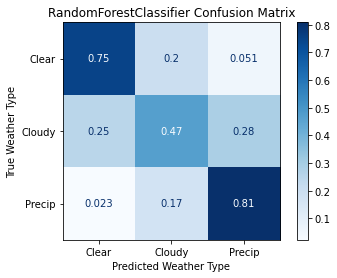

In [114]:
from sklearn.metrics import plot_confusion_matrix
# Plot Confusion matrix
matrix = plot_confusion_matrix(rf, x_test, y_test, cmap=plt.cm.Blues, normalize='true', display_labels=wtype)
plt.xlabel('Predicted Weather Type')
plt.ylabel('True Weather Type')
plt.title("RandomForestClassifier Confusion Matrix")
plt.show()

In [105]:
# Produce confusion matrix for printing
confmat = confusion_matrix(y_test, y_pred, normalize='true')

# Print True positive rates
print("True positive rates for: \n Clear -  " + str("{:.2f}".format(confmat[0][0])) + "\n Cloudy - " + str("{:.2f}".format(confmat[1][1])) + "\n Precip - " + str("{:.2f}".format(confmat[2][2])))

# Print change of rain forecast on clear day
print("Probability that rain is forecast on a clear day: " + str("{:.2f}".format(100*confmat[0][2])) + "%")

True positive rates for: 
 Clear -  0.75
 Cloudy - 0.47
 Precip - 0.81
Probability that rain is forecast on a clear day: 5.11%


The most important feature is Pressure with a value of 0.264


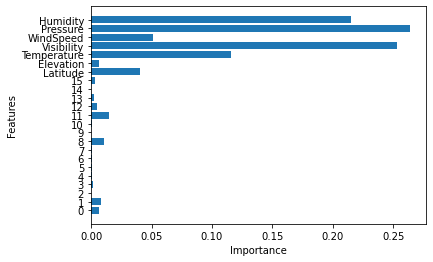

In [106]:
# Calculate the importance, and list y ticks
importance = rf.feature_importances_
ytix = list(range(16))+features[:-1]

# Given plotting example for feature importance
plt.barh(range(23), importance)
plt.yticks(range(23), ytix)
plt.xlabel("Importance")
plt.ylabel("Features")
# Print the most important feature
print("The most important feature is " + str(ytix[np.argmax(importance)]) +  " with a value of " + str("{:.3f}".format(np.amax(importance))))

#### 8. Standardise the relevant features (0.5 mark)

_Note:_ You shouldn't standardise the one-hot encoded wind directions; they already have the desired format. Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
- Hint:

    - Use the scikit-learn `StandardScaler`
    - Or use the scikit-learn `MinMaxScaler`

- Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
    - The number of columns should match, and depending on the choice of standardisation, the last 7 columns should either have:
      - (Using `StandardScaler`) means = 0 and standard deviations = 1; or
      - (Using `MinMaxScaler`) min = 0, max = 1

In [107]:
# Standardise the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sample[features[:-1]])
# Print for proof
print(scaled_data.mean(),scaled_data.std())

# Concat the wind directions to the scaled data
scaled_fdata = np.concatenate((winddir,scaled_data), axis = 1)


-1.6086300847684445e-16 1.0


#### 9. Split the dataset into a training and a testing part (0.5)

Reserve **30%** of data for testing. Check whether the resulting arrays have the expected shapes.

In [108]:
# Split data
Xs_train, Xs_test, ys_train, ys_test = train_test_split(scaled_fdata, y, test_size=0.3, random_state=1) 
# Print shapes, expect (7350, 23) (3150, 23) (7350,) (3150,)
print(Xs_train.shape,Xs_test.shape,ys_train.shape,ys_test.shape)

(7350, 23) (3150, 23) (7350,) (3150,)


## 3. Neural networks in `scikit-learn` (1.5 mark)
---
This section covers **2** exercises on constructing and training neural networks using the `scikit-learn` library, as well as evaluating neural network performance. `scikit-learn` provide many, very easy to use ML algorithms, including neural networks. These are called `MLPClassifier` (MLP = multi-layer perceptron; a historic name for densely connected, feed-forward neural networks) when used for classification, and `MLPRegressor` when used for regression. We will focus on the former for now.

In [109]:
# Relevant import(s) for this section
from sklearn.neural_network import MLPClassifier


#### 10. Construct and train a neural network  (1 mark)

- Create an `MLPClassifier` which
    - has **1 hidden layer of 50 neurons** 
    - has **no regularization term**
    - trains for a maximum of **100 epochs** 
    - uses a batch size of **32**
- Fit the classifier using the standard `.fit()` member method.
- Plot the loss function value as a function of number of epochs (0.5 of mark).
  You can access the loss history through the `.loss_curve_` attribute of the `MLPClassifier` instance. 

In [110]:
# Fitting the MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(50),alpha=0,max_iter=100,batch_size=32).fit(Xs_train,ys_train)

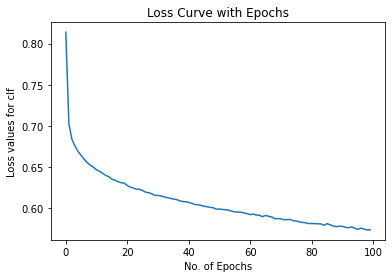

In [152]:
# Plot loss_curve_ against epochs
epochs = np.linspace(0,99,100)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values for clf")
plt.title("Loss Curve with Epochs")
plt.plot(epochs,clf.loss_curve_)
plt.show()

#### 11. Performance evaluation (0.5 mark)

- Using the testing dataset: 
    - Compute the overall accuracy for the classifier using the `MLPClassifier`'s `.score()` member method for both testing and training datasets.
    - Compute the confusion matrix (normalised in true labels), and plot it 
- Discuss the results

Training Data Accuracy: 0.755
Testing Data Accuracy: 0.688


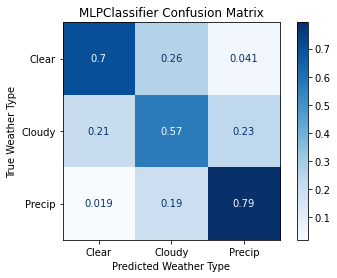

In [113]:
# Print overall mean accuracy

print("Training Data Accuracy: " + str("{:.3f}".format(clf.score(Xs_train,ys_train))))

print("Testing Data Accuracy: " + str("{:.3f}".format(clf.score(Xs_test,ys_test))))

# Confusion matrix
cmatrix = plot_confusion_matrix(clf, Xs_test, ys_test, cmap=plt.cm.Blues, normalize='true', display_labels=wtype)
plt.xlabel('Predicted Weather Type')
plt.ylabel('True Weather Type')
plt.title("MLPClassifier Confusion Matrix")
plt.show()


# _Discussing the results_

The confusion matrix for the MLPClassifier and RandomForestClassifier are very similar with the majority of the probabilities being along the diagonal in both cases (demonstrating similar learning capability for both models), although the MLPClassifier performs slightly better (total accurate predictions is slightly better for MLP).

The data accuracy for MLPClassifier is concerning though, as the training data accuracy is greater than the testing data accuracy by rather large margin. This could be showing us that this model has been overtrained. 

## 4. Neural networks in `Keras` (2 marks)
---
This section covers **2** exercises on constructing and training neural networks using the `Keras` library. `scikit-learn` is very easy to use, but libraries like `Keras` provide a lot more flexibility, which is why we will be using these extensively in the last two units of the _'Data science tools and machine learning'_ track.

In [166]:
# Relevant import(s) for this section
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense

#### 12. Construct a neural network in `Keras` (1 mark)

- Create a `keras.Model` using the **Keras functional API**. The network should have:
    - An input layer with the same number of nodes as the number of features in `X`.
    - A single, densely connected hidden layer with **50 nodes** equipped with **ReLU activation**.
    - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
- Compile the model the using the **Adam optimiser**, add `'accuracy'` as metric, and use either:
    - `categorical_crossentropy` loss, if you have one-hot encoded the targets `y`, or
    - `sparse_categorical_crossentropy` loss if you hare using integer-valued targets.
- Use the `.summary()` member method to print an overview of the model you have created, explain the output.

In [167]:
# Create keras model
inpt = Input(shape=(Xs_train.shape[1]))
layer = Dense(50, activation='relu')(inpt)
output = Dense(3,activation='softmax')(layer)
kf = Model(inputs=inpt, outputs=output,name='KerasNN')

In [168]:
# Compile using Adam optimiser
kf.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=["accuracy"])

# Summary of Model
kf.summary()

Model: "KerasNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                1200      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 153       
Total params: 1,353
Trainable params: 1,353
Non-trainable params: 0
_________________________________________________________________


The summary outputs the separate layers in an order (input (5), dense hidden (8), and dense output (9)).

It then shows you the 'Output Shape' or nodes of each layer, which are 23, then 50, then 3 as described in the instructions.

Then the free parameters are shown for each layer, in this case all parameters are free.

#### 13. Train a `Keras` neural network (1 mark)

- Use the `.fit()` member method to train the network on the **training dataset** for **100 epochs** with a **batch size of 32**. Use **20% of the data for validation** and make sure to have `Keras` **shuffle** the training data between epochs. Save the fit history by doing `history_mld = .....`
- Print the classification accuracy using the `.evaluate()` member method, for both the training and testing dataset. Comment on the results.
- Plot val_loss and loss functions from the fit history. On the same plot, plot the sklearn curve from the excercise above. Note the sklearn NN does not provide a complementary validation loss history, so only plot the training loss.
- Comment on the results of the overall accuracy compared to the scikit-learn method.

In [169]:
# Fitting Keras using instructions above, and save to kff
kff = kf.fit(Xs_train,ys_train, epochs = 100, batch_size = 32, validation_split = 0.2, shuffle = True)

Epoch 1/100
184/184 [==============================] - 0s 1ms/step - loss: 0.9859 - accuracy: 0.4764 - val_loss: 0.7530 - val_accuracy: 0.6422
Epoch 2/100
184/184 [==============================] - 0s 920us/step - loss: 0.7341 - accuracy: 0.6653 - val_loss: 0.7032 - val_accuracy: 0.6701
Epoch 3/100
184/184 [==============================] - 0s 977us/step - loss: 0.6958 - accuracy: 0.6784 - val_loss: 0.6894 - val_accuracy: 0.6810
Epoch 4/100
184/184 [==============================] - 0s 891us/step - loss: 0.6950 - accuracy: 0.6838 - val_loss: 0.6844 - val_accuracy: 0.6844
Epoch 5/100
184/184 [==============================] - 0s 1ms/step - loss: 0.6660 - accuracy: 0.7008 - val_loss: 0.6822 - val_accuracy: 0.6844
Epoch 6/100
184/184 [==============================] - 0s 941us/step - loss: 0.6670 - accuracy: 0.6995 - val_loss: 0.6749 - val_accuracy: 0.6939
Epoch 7/100
184/184 [==============================] - 0s 1ms/step - loss: 0.6692 - accuracy: 0.6891 - val_loss: 0.6763 - val_accuracy

184/184 [==============================] - 0s 728us/step - loss: 0.5676 - accuracy: 0.7535 - val_loss: 0.6775 - val_accuracy: 0.6952
Epoch 58/100
184/184 [==============================] - 0s 720us/step - loss: 0.5918 - accuracy: 0.7422 - val_loss: 0.6790 - val_accuracy: 0.6884
Epoch 59/100
184/184 [==============================] - 0s 801us/step - loss: 0.5804 - accuracy: 0.7485 - val_loss: 0.6853 - val_accuracy: 0.6837
Epoch 60/100
184/184 [==============================] - 0s 782us/step - loss: 0.5815 - accuracy: 0.7457 - val_loss: 0.6766 - val_accuracy: 0.6918
Epoch 61/100
184/184 [==============================] - 0s 731us/step - loss: 0.5808 - accuracy: 0.7435 - val_loss: 0.6718 - val_accuracy: 0.6959
Epoch 62/100
184/184 [==============================] - 0s 821us/step - loss: 0.5706 - accuracy: 0.7509 - val_loss: 0.6791 - val_accuracy: 0.6952
Epoch 63/100
184/184 [==============================] - 0s 727us/step - loss: 0.5740 - accuracy: 0.7481 - val_loss: 0.6772 - val_accuracy

In [170]:
# Print classification accuracy and loss (comes within the evaluate)
print("Test Data Accuracy & Loss")
stest_results = kf.evaluate(Xs_test,ys_test)

print("\n")
print("Training Data Accuracy & Loss")
strain_results = kf.evaluate(Xs_train,ys_train)


Test Data Accuracy & Loss
99/99 [==============================] - 0s 557us/step - loss: 0.6889 - accuracy: 0.6930


Training Data Accuracy & Loss
230/230 [==============================] - 0s 431us/step - loss: 0.5796 - accuracy: 0.7472


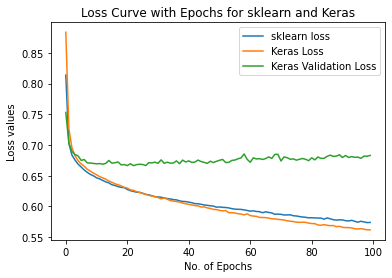

In [171]:
#print(kff.history)
# 
epochs = np.linspace(0,99,100)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("Loss Curve with Epochs for sklearn and Keras")
plt.plot(epochs,clf.loss_curve_, label = 'sklearn loss')
plt.plot(epochs,kff.history['loss'], label = 'Keras Loss')
plt.plot(epochs,kff.history['val_loss'], label = 'Keras Validation Loss')
plt.legend()
plt.show()

While the sklearn and Keras loss are quite similar over the 100 epochs, with Keras even slightly outperforming sklearn, the validation loss demonstrates that what is most likely occurring beyond 5 or so epochs is purely overfitting as the loss flattens out and even increases for out test values.

## 5. Regularisation (1.5 marks)
---
This section covers **2** exercises on the impact of weight regularisaton. Note that $L_{1}$- and $L_{2}$-regularisation may also be applied to the activation of intermediate layers. Also, a similar regularising effect could be achieved using **dropout** regularisation, which you are encouraged to try out, but which we won't study in this CP exercise.

In [183]:
# Relevant import(s) for this section
from tensorflow.python.keras.regularizers import l1_l2

#### 14. Define `Keras` model factory method (0.5 mark)

- Define a python function called `big_model_fn` which takes the followng three arguments:
    - `l1`: A float specifying the $L_{1}$ regularisation factor (default value: 0)
    - `l2`: A float specifying the $L_{2}$ regularisation factor (default value: 0)
    - `name`: A string, specifying the name of the model (default value: None)
- Indside the function, you should:
    - Construct a `Keras` model using the functional API, which has:
        - An input layer with the same number of nodes as the number of features in `X`.
        - **Two** densely connected hidden layer with **100 nodes** each, both equipped with **ReLU activation**.
        - Both hidden layers should be subject to kernel regularisation (_i.e._ weight regularisation) with the regularisation factors specified as an input.
        - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
        - A name given by the corresponding argument.
    - Compile the model in the same way as in **Exercise 14.**
- The function should return the compiled `Keras` model. 

The method will provide a convenient way of constructing and compiling a number of "big"/deep `Keras` models which differ only by their regularisation and name.

In [186]:
def big_model_fn(l1 = 0,l2 = 0,name = "None"):
    
    # Create keras model
    binput = Input(shape=(Xs_train.shape[1],))
    layer1 = Dense(100, activation='relu',kernel_regularizer = l1_l2(l1=l1,l2=l2))(binput)
    layer2 = Dense(100, activation='relu',kernel_regularizer = l1_l2(l1=l1,l2=l2))(layer1)
    output = Dense(3,activation='softmax')(layer2)
    kf = Model(inputs=binput, outputs=output,name=name)
    
    # Compile using Adam optimiser
    kf.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=["accuracy"])
    return kf

#### 15. Train "big" models with and without regularisation (1 mark)

- Construct three "big" model using the factory method:
     - One with default parameters
     - One with `l1=0.0003` and  `name='Big model (L1-regularised)'`
     - One with `l2=0.003`  and `name='Big model (L2-regularised)'`
- Train each one as in **Exercise 15.**
- Compare first the loss history of the un-regularised "big" model to that of the small model from **Exercise 15** using the `plot.loss()` method.
- Then, compare the loss histories of all three "big" models with that of the small model.
- Plot the loss and val loss of all 4 models and discuss the results. Target these points:
    - Compare the performance of deep vs shallow models on the testing sets
    - Compare the level of ovetraining (training vs testing loss)
    - Note: Don't be alarmed if the shallow network performs slightly better that the deeper ones, this is dataset dependant.

In [192]:
# One model with default parameters
model1 = big_model_fn()

# One model with l1 = 0.0003
model2 = big_model_fn(0.0003,0,'Big_model_L1_regularised')

# One model with l2 = 0.003
model3 = big_model_fn(0.003,0,'Big_model_L1_regularised')



In [193]:
# Training as is shown in exercise 15

hist1 = model1.fit(Xs_train,ys_train, epochs = 100, batch_size = 32, validation_split = 0.2, shuffle = True)
hist2 = model2.fit(Xs_train,ys_train, epochs = 100, batch_size = 32, validation_split = 0.2, shuffle = True)
hist3 = model3.fit(Xs_train,ys_train, epochs = 100, batch_size = 32, validation_split = 0.2, shuffle = True)


Epoch 1/100
184/184 [==============================] - 0s 1ms/step - loss: 0.8739 - accuracy: 0.5712 - val_loss: 0.7009 - val_accuracy: 0.6735
Epoch 2/100
184/184 [==============================] - 0s 940us/step - loss: 0.6742 - accuracy: 0.6884 - val_loss: 0.6772 - val_accuracy: 0.6850
Epoch 3/100
184/184 [==============================] - 0s 976us/step - loss: 0.6559 - accuracy: 0.6926 - val_loss: 0.6656 - val_accuracy: 0.7014
Epoch 4/100
184/184 [==============================] - 0s 1ms/step - loss: 0.6549 - accuracy: 0.7039 - val_loss: 0.6762 - val_accuracy: 0.6918
Epoch 5/100
184/184 [==============================] - 0s 1ms/step - loss: 0.6232 - accuracy: 0.7245 - val_loss: 0.6621 - val_accuracy: 0.6986
Epoch 6/100
184/184 [==============================] - 0s 921us/step - loss: 0.6173 - accuracy: 0.7245 - val_loss: 0.6587 - val_accuracy: 0.7027
Epoch 7/100
184/184 [==============================] - 0s 906us/step - loss: 0.6168 - accuracy: 0.7211 - val_loss: 0.6610 - val_accuracy

184/184 [==============================] - 0s 732us/step - loss: 0.3124 - accuracy: 0.8811 - val_loss: 0.8286 - val_accuracy: 0.6755
Epoch 58/100
184/184 [==============================] - 0s 714us/step - loss: 0.3292 - accuracy: 0.8696 - val_loss: 0.8659 - val_accuracy: 0.6776
Epoch 59/100
184/184 [==============================] - 0s 701us/step - loss: 0.3168 - accuracy: 0.8780 - val_loss: 0.8425 - val_accuracy: 0.6714
Epoch 60/100
184/184 [==============================] - 0s 737us/step - loss: 0.3066 - accuracy: 0.8817 - val_loss: 0.8554 - val_accuracy: 0.6748
Epoch 61/100
184/184 [==============================] - 0s 768us/step - loss: 0.3148 - accuracy: 0.8783 - val_loss: 0.8477 - val_accuracy: 0.6830
Epoch 62/100
184/184 [==============================] - 0s 728us/step - loss: 0.2993 - accuracy: 0.8834 - val_loss: 0.8685 - val_accuracy: 0.6769
Epoch 63/100
184/184 [==============================] - 0s 743us/step - loss: 0.2921 - accuracy: 0.8890 - val_loss: 0.8627 - val_accuracy

184/184 [==============================] - 0s 858us/step - loss: 0.7129 - accuracy: 0.7082 - val_loss: 0.7397 - val_accuracy: 0.7007
Epoch 14/100
184/184 [==============================] - 0s 918us/step - loss: 0.7126 - accuracy: 0.7051 - val_loss: 0.7461 - val_accuracy: 0.7027
Epoch 15/100
184/184 [==============================] - 0s 893us/step - loss: 0.6968 - accuracy: 0.7252 - val_loss: 0.7364 - val_accuracy: 0.7000
Epoch 16/100
184/184 [==============================] - 0s 1ms/step - loss: 0.7018 - accuracy: 0.7179 - val_loss: 0.7222 - val_accuracy: 0.7082
Epoch 17/100
184/184 [==============================] - 0s 857us/step - loss: 0.6919 - accuracy: 0.7183 - val_loss: 0.7252 - val_accuracy: 0.7048
Epoch 18/100
184/184 [==============================] - 0s 1ms/step - loss: 0.6847 - accuracy: 0.7273 - val_loss: 0.7314 - val_accuracy: 0.6932
Epoch 19/100
184/184 [==============================] - 0s 881us/step - loss: 0.7006 - accuracy: 0.7249 - val_loss: 0.7371 - val_accuracy: 0.

184/184 [==============================] - 0s 877us/step - loss: 0.6141 - accuracy: 0.7595 - val_loss: 0.7249 - val_accuracy: 0.7027
Epoch 70/100
184/184 [==============================] - 0s 841us/step - loss: 0.6146 - accuracy: 0.7665 - val_loss: 0.7275 - val_accuracy: 0.6959
Epoch 71/100
184/184 [==============================] - 0s 834us/step - loss: 0.6032 - accuracy: 0.7643 - val_loss: 0.7098 - val_accuracy: 0.6986
Epoch 72/100
184/184 [==============================] - 0s 871us/step - loss: 0.6232 - accuracy: 0.7587 - val_loss: 0.7163 - val_accuracy: 0.7007
Epoch 73/100
184/184 [==============================] - 0s 846us/step - loss: 0.6160 - accuracy: 0.7568 - val_loss: 0.7179 - val_accuracy: 0.7027
Epoch 74/100
184/184 [==============================] - 0s 839us/step - loss: 0.6123 - accuracy: 0.7563 - val_loss: 0.7184 - val_accuracy: 0.7007
Epoch 75/100
184/184 [==============================] - 0s 837us/step - loss: 0.5984 - accuracy: 0.7618 - val_loss: 0.7178 - val_accuracy

184/184 [==============================] - 0s 1ms/step - loss: 0.7266 - accuracy: 0.6858 - val_loss: 0.7352 - val_accuracy: 0.6796
Epoch 26/100
184/184 [==============================] - 0s 1ms/step - loss: 0.7439 - accuracy: 0.6790 - val_loss: 0.7342 - val_accuracy: 0.6803
Epoch 27/100
184/184 [==============================] - 0s 2ms/step - loss: 0.7320 - accuracy: 0.6842 - val_loss: 0.7313 - val_accuracy: 0.6769
Epoch 28/100
184/184 [==============================] - 0s 1ms/step - loss: 0.7398 - accuracy: 0.6902 - val_loss: 0.7393 - val_accuracy: 0.6789
Epoch 29/100
184/184 [==============================] - 0s 928us/step - loss: 0.7435 - accuracy: 0.6795 - val_loss: 0.7379 - val_accuracy: 0.6789
Epoch 30/100
184/184 [==============================] - 0s 919us/step - loss: 0.7269 - accuracy: 0.6877 - val_loss: 0.7312 - val_accuracy: 0.6830
Epoch 31/100
184/184 [==============================] - 0s 890us/step - loss: 0.7441 - accuracy: 0.6732 - val_loss: 0.7314 - val_accuracy: 0.6796

184/184 [==============================] - 0s 977us/step - loss: 0.7257 - accuracy: 0.6775 - val_loss: 0.7232 - val_accuracy: 0.6789
Epoch 82/100
184/184 [==============================] - 0s 872us/step - loss: 0.7357 - accuracy: 0.6823 - val_loss: 0.7218 - val_accuracy: 0.6844
Epoch 83/100
184/184 [==============================] - 0s 841us/step - loss: 0.7306 - accuracy: 0.6867 - val_loss: 0.7249 - val_accuracy: 0.6776
Epoch 84/100
184/184 [==============================] - 0s 864us/step - loss: 0.7147 - accuracy: 0.6943 - val_loss: 0.7234 - val_accuracy: 0.6803
Epoch 85/100
184/184 [==============================] - 0s 820us/step - loss: 0.7075 - accuracy: 0.6952 - val_loss: 0.7222 - val_accuracy: 0.6755
Epoch 86/100
184/184 [==============================] - 0s 818us/step - loss: 0.7062 - accuracy: 0.6974 - val_loss: 0.7254 - val_accuracy: 0.6898
Epoch 87/100
184/184 [==============================] - 0s 848us/step - loss: 0.7132 - accuracy: 0.6966 - val_loss: 0.7232 - val_accuracy

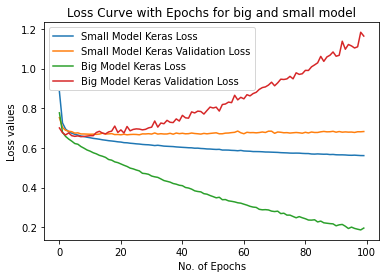

In [194]:
# Big and small model plotting
epochs = np.linspace(0,99,100)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("Loss Curve with Epochs for big and small model")

plt.plot(epochs,kff.history['loss'], label = 'Small Model Keras Loss')
plt.plot(epochs,kff.history['val_loss'], label = 'Small Model Keras Validation Loss')

plt.plot(epochs,hist1.history['loss'], label = 'Big Model Keras Loss')
plt.plot(epochs,hist1.history['val_loss'], label = 'Big Model Keras Validation Loss')

plt.legend()
plt.show()


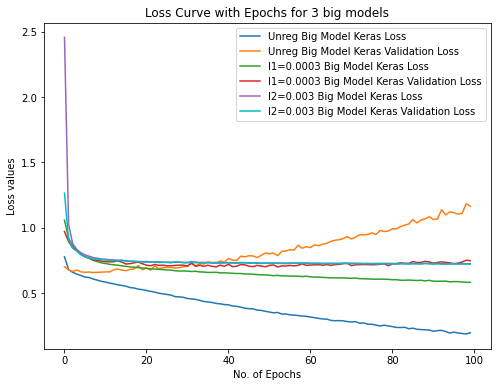

In [209]:
# Plot 3 Big models
epochs = np.linspace(0,99,100)
plt.figure(figsize=(8,6))
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("Loss Curve with Epochs for 3 big models")

# unreg'd model
plt.plot(epochs,hist1.history['loss'], label = 'Unreg Big Model Keras Loss')
plt.plot(epochs,hist1.history['val_loss'], label = 'Unreg Big Model Keras Validation Loss')

# big model l1 reg
plt.plot(epochs,hist2.history['loss'], label = 'l1=0.0003 Big Model Keras Loss')
plt.plot(epochs,hist2.history['val_loss'], label = 'l1=0.0003 Big Model Keras Validation Loss')

# big model l2 reg
plt.plot(epochs,hist3.history['loss'], label = 'l2=0.003 Big Model Keras Loss')
plt.plot(epochs,hist3.history['val_loss'], label = 'l2=0.003 Big Model Keras Validation Loss',color = 'c')


plt.legend()
plt.show()


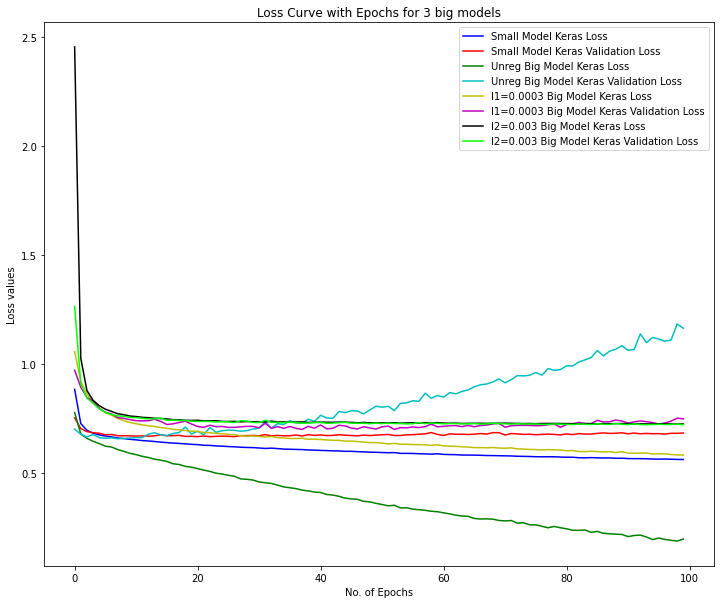

In [211]:
# Plot all 4 Models
epochs = np.linspace(0,99,100)
plt.figure(figsize=(12,10))
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("Loss Curve with Epochs for 3 big models")

# small model
plt.plot(epochs,kff.history['loss'], label = 'Small Model Keras Loss', color = 'b')
plt.plot(epochs,kff.history['val_loss'], label = 'Small Model Keras Validation Loss', color = 'r')

# unreg'd model
plt.plot(epochs,hist1.history['loss'], label = 'Unreg Big Model Keras Loss', color = 'g')
plt.plot(epochs,hist1.history['val_loss'], label = 'Unreg Big Model Keras Validation Loss', color = 'c')

# big model l1 reg
plt.plot(epochs,hist2.history['loss'], label = 'l1=0.0003 Big Model Keras Loss', color = 'y')
plt.plot(epochs,hist2.history['val_loss'], label = 'l1=0.0003 Big Model Keras Validation Loss', color = 'm')

# big model l2 reg
plt.plot(epochs,hist3.history['loss'], label = 'l2=0.003 Big Model Keras Loss', color = 'k')
plt.plot(epochs,hist3.history['val_loss'], label = 'l2=0.003 Big Model Keras Validation Loss', color = 'lime')


plt.legend()
plt.show()


# EXPLANING THE DIFFERENCES IN ALL 4 MODELS
Basically regularisation good, removes overtuning, small model overtuned, big model also very overtuned, l2 and l1 methods better but still overtuned


## 6. Bonus: Hyperparameter optimisation (1\*bonus\* mark)
---

This section covers **1** exercise on the on hyperparameter optimisation. 

In [38]:
# Relevant import(s) for this section
from sklearn.model_selection import GridSearchCV, cross_val_score

---
_**Comment on simplified hyperparameter optimisation example:**_ You will try to perform a simple optimisation using a grid search

For convenience, we will be using the `scikit-learn` `MLPClassifier` as our base class, but the same principles apply to just about any ML model constructed in any framework. Just as in the examples in the lecture, we will restrict the hyperparameter space to just two dimensions:

* the number of hidden layers, `nb_layers`, and
* the number of nodes per hidden layer, `nb_nodes_per_layer`, which is taken to be the same for all hidden layers for simplicity.

Since the `scikit-learn` neural network classifier class doesn't support these two hyperparameters by default, provided is a simple wrapper class, that works exactly like `MLPClassifier`, it just takes the two parameters above as arguments in the constructor. Don't worry about understanding it in detail. This allows us to call 

In [39]:
class MLPClassifierWrapper(MLPClassifier):
    """
    Wrapper around `sklearn.neural_network.MLPClassifier` with a convenient set 
    of properties (nb_layers and nb_nodes_per_layer) suitable for hyperparameter 
    optimisation exercises.
    
    Arguments:
        nb_layers: Integer, number of hidden layers
        nb_nodes_per_layer: Number of nodes per hidden layer, taken to be the 
            same for all for convenience.
    """

    def __init__ (self, nb_layers=1, nb_nodes_per_layer=100, **kwargs):
        
        # Member variables
        self._nb_layers = nb_layers
        self._nb_nodes_per_layer = nb_nodes_per_layer  
        
        # Call base class (`MLPClassifier`) constructor
        super(MLPClassifierWrapper, self).__init__(**kwargs)
        
        # Trigger `_set_architecture`
        self._set_architecture()
        return

    @property
    def nb_layers(self):
        return self._nb_layers
    
    @property
    def nb_nodes_per_layer(self):
        return self._nb_nodes_per_layer 

    @nb_layers.setter
    def nb_layers(self, value):
        self._nb_layers = value
        self._set_architecture()
        return
    
    @nb_nodes_per_layer.setter
    def nb_nodes_per_layer(self, value):
        self._nb_nodes_per_layer = value
        self._set_architecture()
        return
    
    def _set_architecture (self):
        """
        Sets the `hidden_layer_sizes` parameter of the base `MLPClassifier` 
        class, based on the two custom parameters we have chosen.
        """
        
        self.hidden_layer_sizes = tuple([self._nb_nodes_per_layer for _ in range(self._nb_layers)])
        return
    pass

---

#### 16. Perform a grid search (1 mark)

- Construct a python `dict` called `param_grid` which specifies the hyperparameter configurations to try for each parameter dimension. That is, it should have
    - `"nb_layers"` and `"nb_nodes_per_layer"` as keys, and
    - lists of integers as values, corresponding to the values of each parameter you want to try out (_e.g._ [1, 2, ...])
- Choose a reasonable set of values for each parameter; about a handful for each.
- Use the `GridSearchCV` class to perform _**3**_**-fold** cross validation (CV) optimisation of the validation **accuracy**
    - Hint: You can use the `n_jobs=...` argument to enable multi-processing, thereby speeding up the optimisation, at the expense of reproducibility.
- The base classifier should be an instance of `MLPClassifierWrapper` set to train for **100 epochs**.
- Present the results:
    - Print the best parameter configuration found. GridSearchCV has a public member which stores this. Read doc.
    - Print the mean and standard deviation of the test scores for the best configuration found. (_Hint:_ These can be found in the `.cv_results_` attribute)
    - Plot the optimisation results using the `plot.optimisation` method.
- Discuss the results. What would happen if the best result is foundon the edge of the parameter grid?